##Загрузка всякого

In [ ]:
!pip install scikit-plot

In [ ]:
import numpy as np 
import pandas as pd
import math
import numpy as np
import pandas as pd
import os
import cv2

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/zxc/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


##Смотрим на датасет

In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

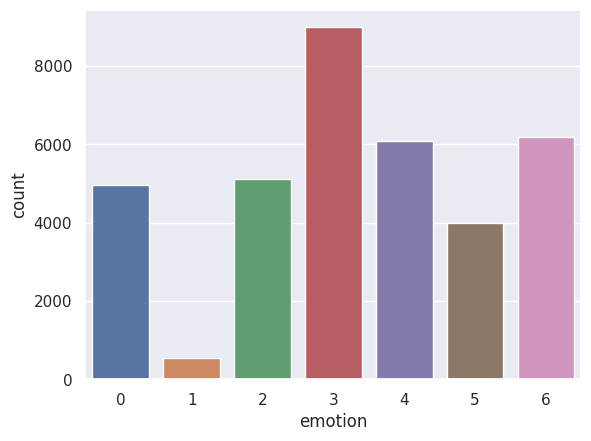

In [ ]:
sns.countplot(x=df.emotion)

So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.

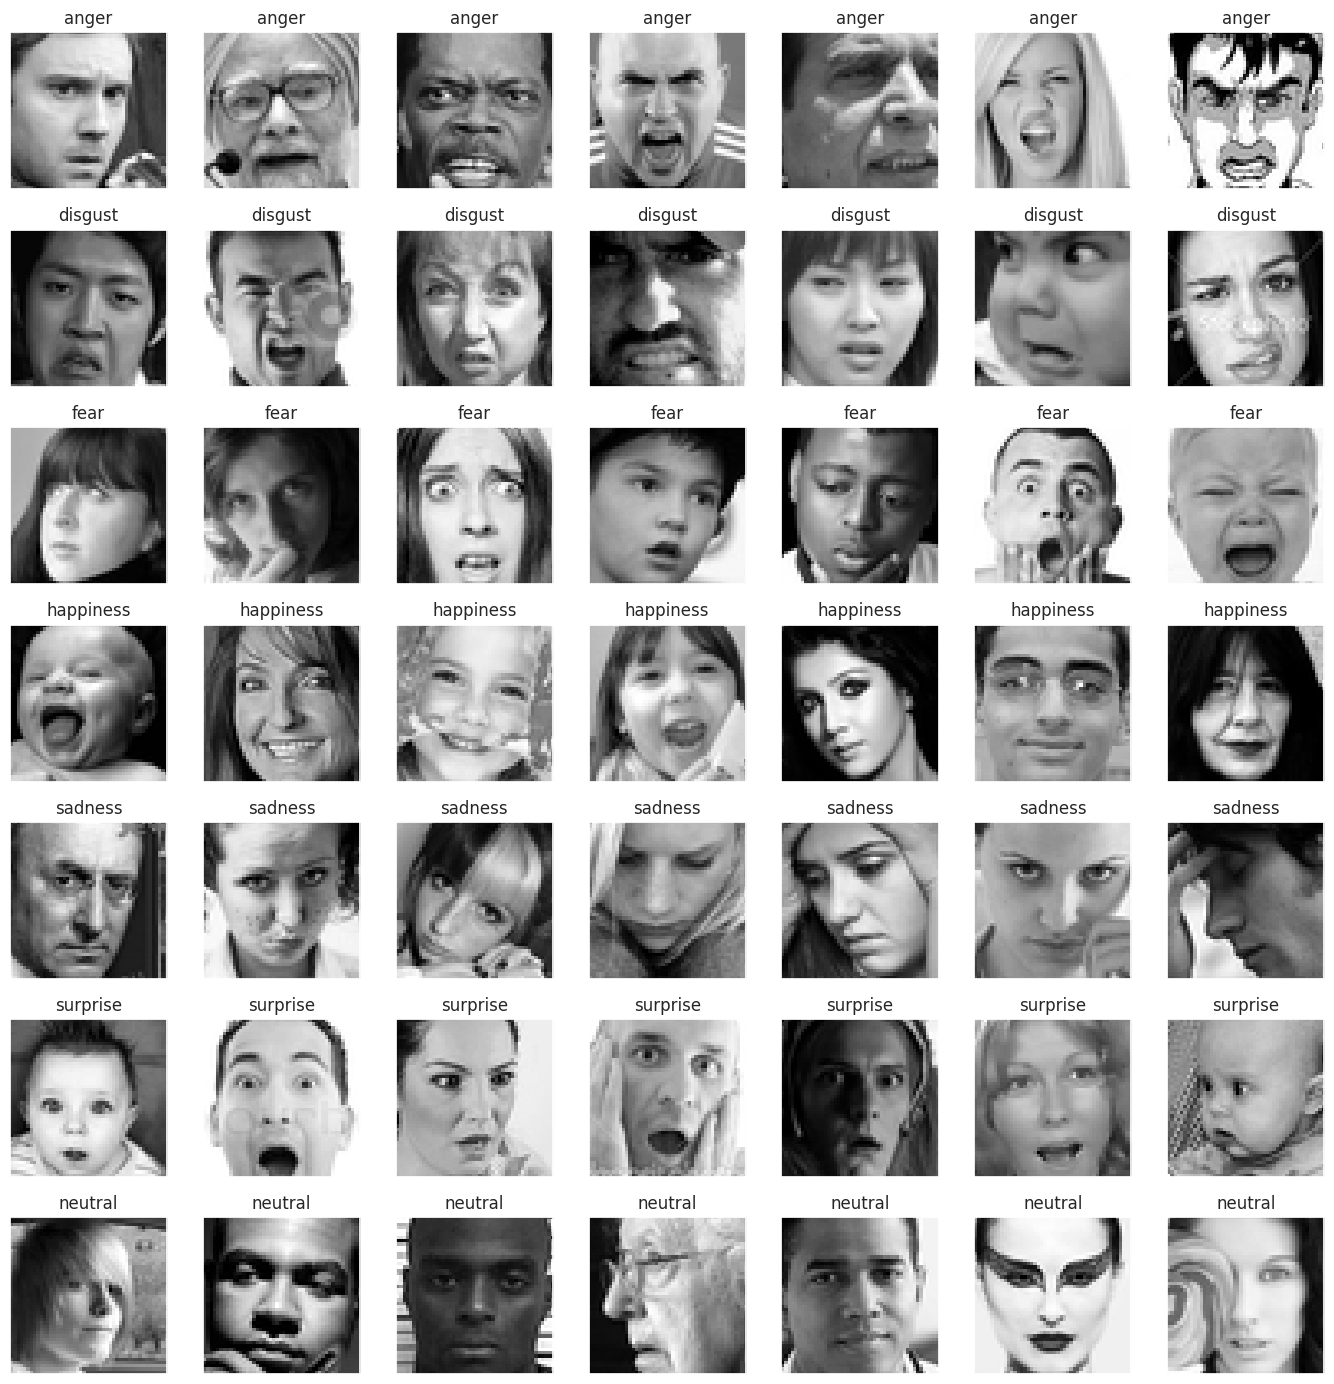

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

Now I will make the data compatible for neural networks.

## Подготовка данных

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(35887, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


Splitting the data into training and validation set.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

## Определяем сеточку

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

logger = CSVLogger(
    '/content/drive/MyDrive/zxc/history.csv',
    separator = ',',
    append = True
)

callbacks = [
    early_stopping,
    lr_scheduler,
    logger
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
optim = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')

model_name = "/content/drive/MyDrive/zxc/my_model"
batch_size = 32

if os.path.exists(model_name):
  model = load_model(model_name)
  start = pd.read_csv('/content/drive/MyDrive/zxc/history.csv', sep=',')
  start = start['epoch'].iloc[-1]
  print("zxc")
else:
  model = build_net(optim)
  print("zalupa")

zxc


## Обучаем сеточку

In [ ]:
epochs = 20
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True,
    initial=start
)

model.save(model_name)

##Картиночки

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [ ]:
yhat_valid = model.predict(X_valid)
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != np.argmax(yhat_valid, axis=1))} from {np.sum(np.argmax(y_valid, axis=1))}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), np.argmax(yhat_valid, axis=1)))
scikitplot.metrics.confusion_matrix(np.argmax(y_valid, axis=1), np.argmax(yhat_valid, axis=1))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        pred = model.predict(sample_img.reshape(1,48,48,1))[0]
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(pred)]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        pred = model.predict(sample_img.reshape(1,48,48,1))[0]
        ax.set_title(f"t:neut, p:{mapper[np.argmax(pred)]}")

        pyplot.tight_layout()